## Activity 13


I have digitized the data points of Figure 6 in DeBarros et al. (2019).
The detections (filled circles) are included in the file DeBarrosFigure6_detections.data, while the upper limits (left censored data, open circles) are in the file DeBarrosFigure6_NONdetections.data

<img src="DeBarros2019_Figure6.png" alt="DeBarros et al. 2019 Figure 6" width="600"/>

Perform a Bayesian regression of the data 1) removing the upper limits, 2) treating upper limits as detections and 3) properly trating upper limits. In 3) you have to find a way to generalize the analysis we did in class to include a different upper limit for every point. 

Compare your results with those of DeBarros et al. :

$$
\log({\rm L([O III]+H\beta)/ erg\, s}^{-1}) = 0.86 \pm 0.12 \log({\rm L_{UV}/ erg\, s}^{-1}) + 33.92^{+1.23}_{-1.27}
$$



Haoxiang Li Email: li001294@umn.edu

Send me an email and let me know if you find any typos or mistakes. All suggestions are greatly appreciated!

Follow the "Bayesian Analysis Reporting Guidelines" for your final report.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from scipy import stats
from numpy.random import default_rng
import pymc as pm
import xarray as xr

from pymc.distributions.dist_math import normal_lccdf, normal_lcdf
from scipy.stats import norm, truncnorm
from copy import copy


In [ ]:
detect = pd.read_csv("DeBarrosFigure6_detections.data", sep="\t")
nondetect = pd.read_csv("DeBarrosFigure6_NONdetections.data", sep="\t")

In [ ]:
detect = detect.rename(columns = {' LogUV':'LogUV'})
nondetect = nondetect.rename(columns = {' LogUV':'LogUV'})

In [ ]:
detect.columns

Index(['LogUV', 'Log(OIII+Hb)'], dtype='object')

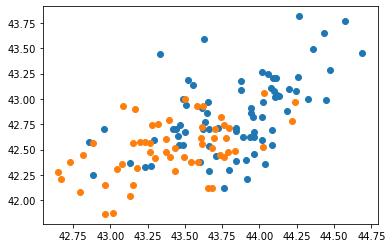

In [ ]:
plt.scatter(detect['LogUV'], detect['Log(OIII+Hb)']) # blue
plt.scatter(nondetect['LogUV'], nondetect['Log(OIII+Hb)']) # organge

In [ ]:
def lregression(x, y):
    with pm.Model() as model:
        slope = pm.Normal("slope", mu=0, sigma=1)
        intercept = pm.Normal("intercept", mu=0, sigma=1)
        σ = pm.HalfNormal("σ", sigma=1)
        y_likelihood = pm.Normal("y_likelihood", mu=slope * x + intercept, sigma=σ, observed=y)
    return model

In [ ]:
#q1 removing the upper limits
q1_model = lregression(detect['LogUV'], detect['Log(OIII+Hb)'])

with q1_model:
    q1_fit = pm.sample(return_inferencedata=True, draws = 4000, chains=2, cores=2)

In [ ]:
detect["Censored"] = np.repeat(False, detect.shape[0])
nondetect["Censored"] = np.repeat(True, nondetect.shape[0])
data = pd.concat([detect, nondetect], ignore_index=True)
data

,LogUV,Log(OIII+Hb),Censored
0,44.689453,43.455803,False
1,44.572765,43.765194,False
2,44.431507,43.649170,False
3,44.471428,43.281770,False
4,44.360880,43.494476,False
...,...,...,...
126,42.794792,42.082874,True
127,42.819360,42.443832,True
128,42.733380,42.379375,True
129,42.668890,42.205340,True


In [ ]:
#q2 removing the upper limits
q2_model = lregression(data['LogUV'], data['Log(OIII+Hb)'])

with q2_model:
    q2_fit = pm.sample(return_inferencedata=True, draws = 4000, chains=2, cores=2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feaac835c70>,
      dtype=object)

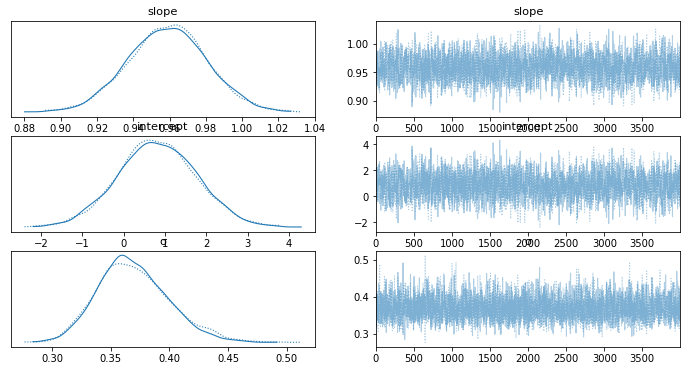

In [ ]:
az.plot_trace(q1_fit)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feaaeac2b50>,
      dtype=object)

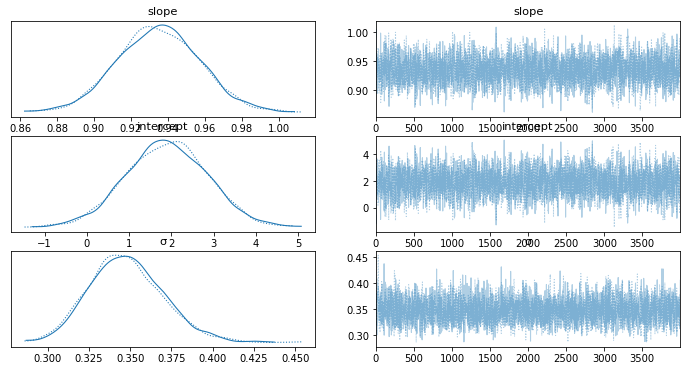

In [ ]:
az.plot_trace(q2_fit)

[Text(0.5, 0, 'slope'), Text(0.5, 1.0, 'Linear regression\n(q2)')]

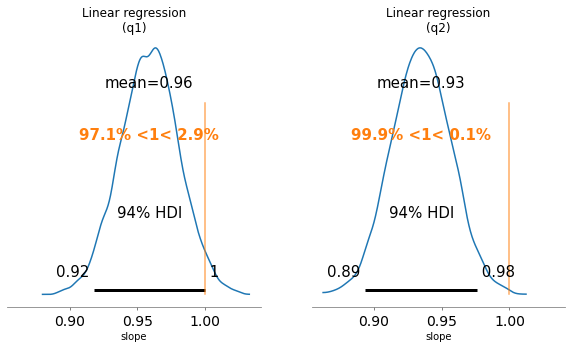

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

az.plot_posterior(q1_fit, var_names=["slope"], ref_val=1, ax=ax[0])
ax[0].set(title="Linear regression\n(q1)", xlabel="slope")

az.plot_posterior(q2_fit, var_names=["slope"], ref_val=1, ax=ax[1])
ax[1].set(title="Linear regression\n(q2)", xlabel="slope")

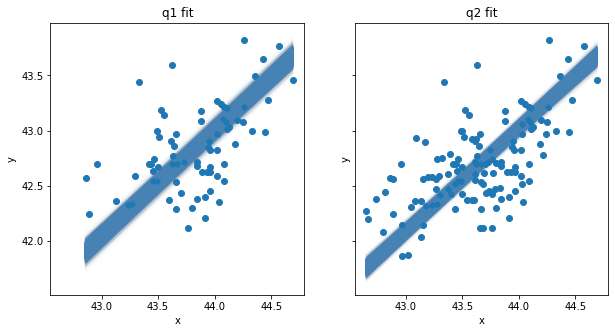

In [ ]:
def pp_plot(xx, yy, fit, ax,true=True):
    # plot posterior predicted... samples from posterior
    xi = xr.DataArray(np.array([np.min(xx), np.max(xx)]), dims=["obs_id"])
    post = fit.posterior
    y_ppc = xi * post["slope"] + post["intercept"]
    ax.plot(xi, y_ppc.stack(sample=("chain", "draw")), c="steelblue", alpha=0.01, rasterized=True)
    ax.set(xlabel="x", ylabel="y")


fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(detect['LogUV'], detect['Log(OIII+Hb)'])
pp_plot(detect['LogUV'], detect['Log(OIII+Hb)'], q1_fit, ax[0],true=True)
ax[0].set(title="q1 fit")

ax[1].scatter(data['LogUV'], data['Log(OIII+Hb)'])
pp_plot(data['LogUV'], data['Log(OIII+Hb)'], q2_fit, ax[1],true=True)
ax[1].set(title="q2 fit");

In [ ]:
# q3 bounds

def censored_regression(xx, yy, censored):

    # data pre-processing
    left_censored = censored == True
    x_lc = xx[left_censored]
    y_lc = yy[left_censored]

    uncensored = left_censored == False

    xu = xx[uncensored]
    yu = yy[uncensored]

    with pm.Model() as model:
        slope = pm.Normal("slope", mu=0, sigma=1)
        intercept = pm.Normal("intercept", mu=0, sigma=1)
        σ = pm.HalfNormal("σ", sigma=1)
        y_likelihood = pm.Normal("y_likelihood", mu=slope * xu + intercept, sigma=σ, observed=yu)
        left_censored = pm.Potential(
            "left_censored", normal_lcdf(slope * x_lc + intercept, σ, y_lc)
        )

    return model



In [162]:
censored_model = censored_regression(data['LogUV'].values, data['Log(OIII+Hb)'].values, data["Censored"].values) # x, y has to be array

with censored_model:
    censored_fit = pm.sample(return_inferencedata=True, draws = 4000, chains=2, cores=2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feaad1c4d30>,
      dtype=object)

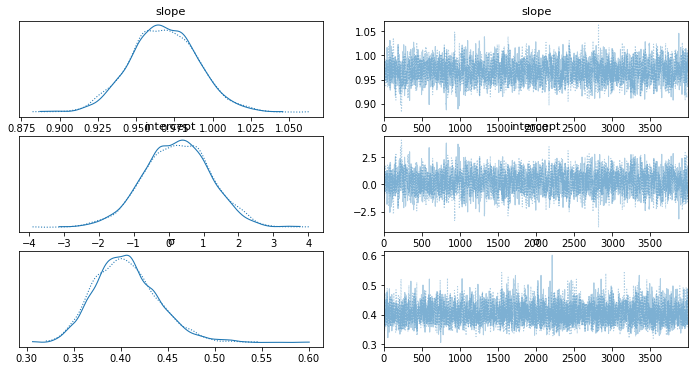

In [163]:
az.plot_trace(censored_fit)

[Text(0.5, 0, 'slope'), Text(0.5, 1.0, 'Linear regression\n(q3)')]

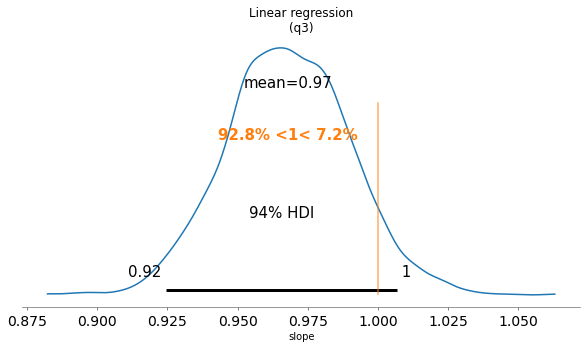

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

az.plot_posterior(censored_fit, var_names=["slope"], ref_val=1, ax=ax)
ax.set(title="Linear regression\n(q3)", xlabel="slope")

[Text(0.5, 1.0, 'censored fit')]

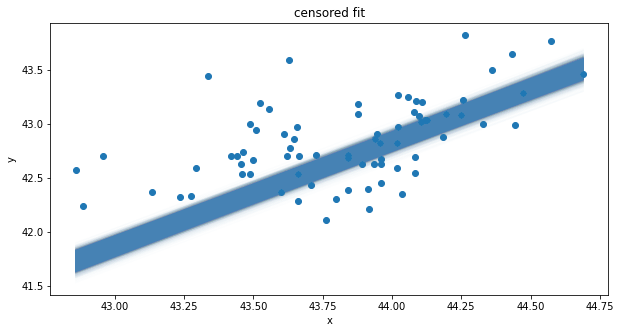

In [165]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True, sharey=True)
ax.scatter(detect['LogUV'], detect['Log(OIII+Hb)'])
pp_plot(detect['LogUV'], detect['Log(OIII+Hb)'], censored_fit, ax,true=True)
ax.set(title="censored fit")